In [1]:
#utils.py - cell1

cell1='''
import logging

class CustomFormatter(logging.Formatter):

    grey = "\x1b[38;20m"
    yellow = "\x1b[33;20m"
    red = "\x1b[31;20m"
    bold_red = "\x1b[31;1m"
    reset = "\x1b[0m"
    format = "%(asctime)s - %(name)s - %(levelname)s - %(message)s (%(filename)s:%(lineno)d)"

    FORMATS = {
        logging.DEBUG: grey + format + reset,
        logging.INFO: grey + format + reset,
        logging.WARNING: yellow + format + reset,
        logging.ERROR: red + format + reset,
        logging.CRITICAL: bold_red + format + reset
    }

    def format(self, record):
        log_fmt = self.FORMATS.get(record.levelno)
        formatter = logging.Formatter(log_fmt)
        return formatter.format(record)

class style():
    BLACK = '\033[30m'
    RED = '\033[31m'
    GREEN = '\033[32m'
    YELLOW = '\033[33m'
    BLUE = '\033[34m'
    MAGENTA = '\033[35m'
    CYAN = '\033[36m'
    WHITE = '\033[37m'
    UNDERLINE = '\033[4m'
    RESET = '\033[0m'

class Visualize():
    def plot_samples(data, channel:int, title=None, plot_name="", n_examples =4):

    #     n_rows = int(20 / 5)
    #     plt.figure(figsize=(1* n_rows, 1*n_rows))
    #     if title: plt.suptitle(title)
    #     X, y= data
    #     for idx in range(n_examples):

    #         ax = plt.subplot(n_rows, 5, idx + 1)

    #         image = 255 - X[idx, channel].view((32,32))
    #         ax.imshow(image,cmap='gray')
    #         ax.axis("off")

    #     if plot_name!="":plt.savefig(f"plots/"+plot_name+".png")

    #     plt.tight_layout()
        images, labels = data
        def imshow(img):
            img = img / 2 + 0.5     # unnormalize
            npimg = img.numpy()
            plt.imshow(np.transpose(npimg, (1, 2, 0)))
            plt.show()

        def show(inp, label):
            fig = plt.gcf()
            plt.imshow(inp.permute(1,2,0))
            plt.title(title)
        # get some random training images

        grid = torchvision.utils.make_grid(images)
        labels = torch.tensor([0,1,0,0])
        show(grid, label=[int(labels[x])for x in range(len(labels))])

        imshow(torchvision.utils.make_grid(images,padding=1))
        '''

In [2]:
#data.py - cell4

cell2='''
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms as transforms
import json
import os
import torch
from torchvision.datasets import VisionDataset
from torchvision.datasets.utils import check_integrity, download_and_extract_archive

class LISA(VisionDataset):
    base_folder = 'lisa-batches'
    url = "https://github.com/AminJun/lisa/releases/download/v1/lisa.tar.gz"

    zipped = {
        'filename': 'lisa.tar.gz',
        'md5': 'd3e7bd49dc55c2d9240d4b5473848dcb',
    }

    label_file = 'labels.tensor'
    meta_file = 'meta.js'
    images_list = ['images_0.tensor', 'images_1.tensor', 'images_2.tensor']

    checksum = {
        'images_0.tensor': 'ac59f173c4d374859e73be64cee9de41',
        'images_1.tensor': '13df95c1f3b05fc9a90a83cb0febe50f',
        'images_2.tensor': '235f29c99e67019b1ba47dfe2492b461',
        label_file: 'a68f3549adbf898b26f1ab76ab515d38',
        meta_file: 'c52f0f118ff7e03c366608f7ea960d8f',
    }

    def _get_path(self, file: str) -> str:
        return os.path.join(self.root, self.base_folder, file)

    def __init__(self, root, train: bool, download=False, transform=None, target_transform=None):
        super(LISA, self).__init__(root=root, transform=transform, target_transform=target_transform)

        if download:
          self.download()

        if not self._check_integrity():
          raise RuntimeError('Dataset not found or corrupted. You can use download=True to download it')

        self.images = torch.cat([torch.load(self._get_path(file)) for file in self.images_list], 0)
        self.labels = torch.load(self._get_path(self.label_file))
        self._load_meta()

        self.train = train
        self._train_test_split()

        # Move the method call here
        self._plot_class_distribution()
    
    
    def _load_meta(self):
        with open(self._get_path(self.meta_file), 'r') as file:
            data = json.load(file)
            self.classes = data['classes']
            self.class_to_idx = data['name_to_label']

    def __getitem__(self, index) -> (torch.tensor, torch.tensor):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.images[index], self.labels[index]
        img = img if self.transform is None else self.transform(img)
        target = target if self.target_transform is None else self.target_transform(target)
        return img, target

    def __len__(self) -> int:
        return len(self.images)

    def _check_integrity(self) -> bool:
        return all(check_integrity(self._get_path(filename), md5) for filename, md5 in self.checksum.items())

    def download(self):
        if self._check_integrity():
            print('Files already downloaded and verified')
            return
        download_and_extract_archive(self.url, self.root, **self.zipped)

    def extra_repr(self) -> str:
        return "No Split Yet"

    def _train_test_split(self, test_percent: float = 0.16):
        classes = {}
        for i, cl in enumerate(self.labels.numpy()):
            arr = classes.get(cl, [])
            arr.append(i)
            classes[cl] = arr

        train, test = [], []
        for cl, arr in classes.items():
            split_index = int(len(arr) * test_percent)
            test = test + arr[:split_index]
            train = train + arr[split_index:]

        sub = train if self.train else test
        self.images, self.labels = self.images[sub], self.labels[sub]
        
    def _plot_class_distribution(self):
        class_counts = np.unique(self.labels.numpy(), return_counts=True)
        classes, counts = class_counts

        num_classes = len(classes)
        plt.figure(figsize=(10, 5))
        plt.bar(classes, counts)
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.title('Class Distribution')

        # Use class names from dataset metadata
        class_names = [self.classes[label] for label in classes]

        # Set the xticks to the unique label values and replace them with class names
        plt.xticks(classes, class_names, rotation='vertical')

        plt.grid(axis='y')
        plt.text(num_classes-1, max(counts), f'Total Classes: {num_classes}', horizontalalignment='right', verticalalignment='top')

        plt.show()



# transform = transforms.Compose(
#     [    transforms.ToPILImage(),
#      transforms.ToTensor(),
#      transforms.Normalize((0.4563, 0.4076, 0.3895), (0.2298, 0.2144, 0.2259))])
# trainset = LISA(root='./data', download=True, train=True,transform=transform)
# testset = LISA(root='./data', download=True, train=False,transform=transform)  

# trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size,
#                                           shuffle=True)
# testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size,
#                                           shuffle=True)
'''

In [3]:
# clients.py - cell5

cell3='''
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np



def non_iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, shuffle_digits=False):
    assert(nb_nodes>0 and nb_nodes<=10)

    digits=torch.arange(10) if shuffle_digits==False else torch.randperm(10, generator=torch.Generator().manual_seed(0))
    digits2=torch.arange(3) if shuffle_digits==False else torch.randperm(10, generator=torch.Generator().manual_seed(0))

    digits = torch.cat((digits,digits2))

    # split the digits in a fair way
    digits_split=list()
    i=0
    for n in range(nb_nodes, 0, -1):
        inc=int((10-i)/n)
#         print(i)
#         print(n)
        digits_split.append(digits[i:i+3])
        i+=inc
 

    # load and shuffle nb_nodes*n_samples_per_node from the dataset
    loader = torch.utils.data.DataLoader(dataset,
                                        batch_size=nb_nodes*n_samples_per_node,
                                        shuffle=shuffle)
    dataiter = iter(loader)
    images_train_mnist, labels_train_mnist = next(dataiter)

    data_splitted=list()
    for i in range(nb_nodes):
        idx=torch.stack([y_ == labels_train_mnist for y_ in digits_split[i]]).sum(0).bool() # get indices for the digits
        data_splitted.append(torch.utils.data.DataLoader(torch.utils.data.TensorDataset(images_train_mnist[idx], labels_train_mnist[idx]), batch_size=batch_size, shuffle=shuffle))
    return data_splitted


def iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle):
        # load and shuffle n_samples_per_node from the dataset

        loader = torch.utils.data.DataLoader(dataset,
                                            batch_size=n_samples_per_node,
                                            shuffle=shuffle)
        dataiter = iter(loader)
        X,Y= next(iter(loader))
        data_splitted=list()
        for i in range(nb_nodes):
            data_splitted.append(torch.utils.data.DataLoader(torch.utils.data.TensorDataset(*(next(dataiter))), batch_size=batch_size, shuffle=shuffle,))

        

        return data_splitted
        '''

In [4]:
#lisa.py - cell4

cell4='''
import sys
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

#from data import *
exec(cell2)
#from clients import *
exec(cell3)

def  get_LISA(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=4, shuffle=True):
        transform = transforms.Compose(
        [    transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize((0.4563, 0.4076, 0.3895), (0.2298, 0.2144, 0.2259))])
        
        dataset_loaded_train = LISA(root='./data', download=True, train=True,transform=transform)
        dataset_loaded_test = LISA(root='./data', download=True, train=False,transform=transform)

        if type=="iid":
            train=iid_split(dataset_loaded_train, n_clients, n_samples_train, batch_size, shuffle)
            test=iid_split(dataset_loaded_test, n_clients, n_samples_test, batch_size, shuffle)
        elif type=="non_iid":
            train=non_iid_split(dataset_loaded_train, n_clients, n_samples_train, batch_size, shuffle)
            test=non_iid_split(dataset_loaded_test, n_clients, n_samples_test, batch_size, shuffle)
        else:
            train=[]
            test=[]

        return train, test
'''

In [5]:
#VisionTransformer.py - cell5

cell5='''
from torch.nn.modules.transformer import TransformerEncoderLayer, TransformerDecoderLayer

class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, num_classes, in_channels, embed_dim, num_layers, heads, dropout):
        super().__init__()
        assert img_size % patch_size == 0, 'Image dimensions must be divisible by patch size.'
        num_patches = (img_size // patch_size) ** 2
        self.patch_embedding = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.position_embedding = nn.Parameter(torch.zeros(1, num_patches, embed_dim))  # Adjusted size here
        self.dropout = nn.Dropout(dropout)
        self.transformer = nn.ModuleList([
            TransformerEncoderLayer(d_model=embed_dim, nhead=heads, dim_feedforward=embed_dim, dropout=dropout)
            for _ in range(num_layers)])
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embedding(x)
        x = x.flatten(2).transpose(1, 2)
        x = self.dropout(x)
        for layer in self.transformer:
            x = layer(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x
'''


 Runtime Device:cuda

OPTIMIZER: adam
Data Split: iid
COMM_ROUNDS: 100
POISON CLIENTS: 10
BATCH SIZE: 5
LOCAL EPOCHS: 5
LEARNING RATE: 0.003
POISON LEVEL: 20
2


100%|██████████| 26388978/26388978 [00:00<00:00, 311931832.48it/s]


Extracting ./data/lisa.tar.gz to ./data


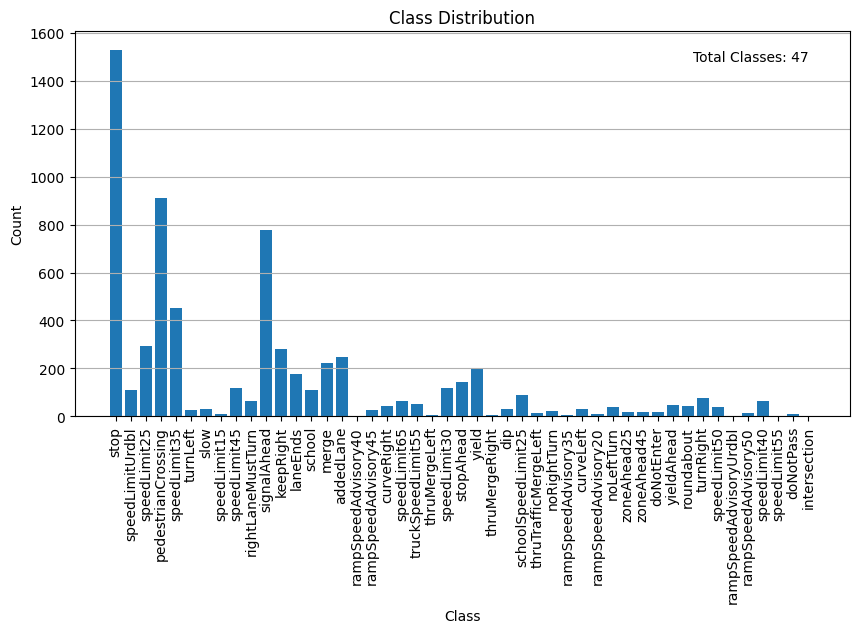

Files already downloaded and verified


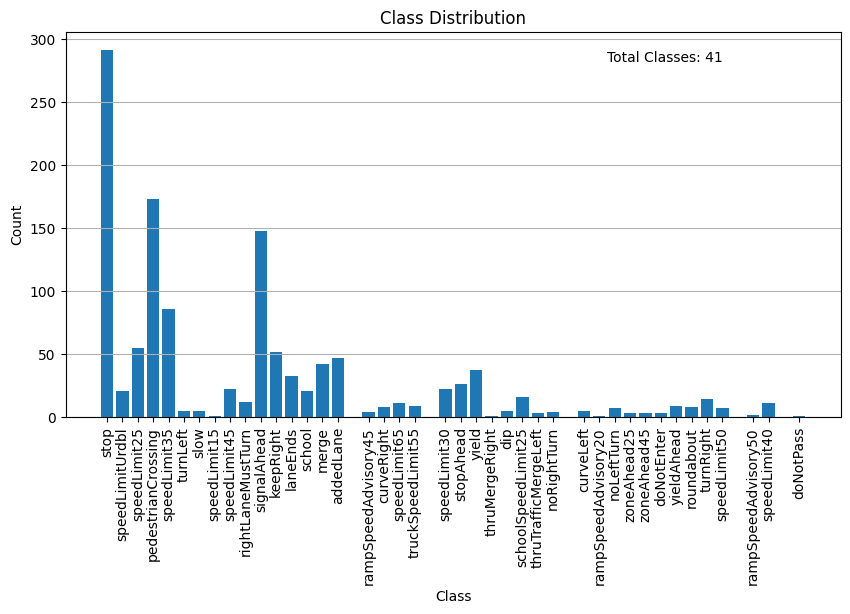

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Clients' weights: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
====> i: 0 Loss: 3.911565685272217 Server Test Accuracy: 1.0
[]
0---local_loss--- 2.780538558959961
1---local_loss--- 2.682215452194214
2---local_loss--- 2.2107908725738525
3---local_loss--- 1.9759609699249268
4---local_loss--- 2.2228591442108154
5---local_loss--- 1.9306968450546265
6---local_loss--- 2.1069228649139404
7---local_loss--- 2.3080618381500244
8---local_loss--- 2.201237678527832
9---local_loss--- 2.2957444190979004
====> i: 1 Loss: 2.3885346651077275 Server Test Accuracy: 22.8
[]
0---local_loss--- 2.8048555850982666
1---local_loss--- 2.589716911315918
2---local_loss--- 1.7597991228103638
3---local_loss--- 1.6603988409042358
4---local_loss--- 1.659449815750122
5---local_loss--- 1.6449487209320068
6---local_loss--- 1.6210246086120605
7---local_loss--- 1.806040644645691
8---local_loss--- 1.75077486038208
9---local_loss--- 1.9553195238113403
====> i: 2 Loss: 2.228615987300873 Server Test Accuracy: 33.4
[]
0---

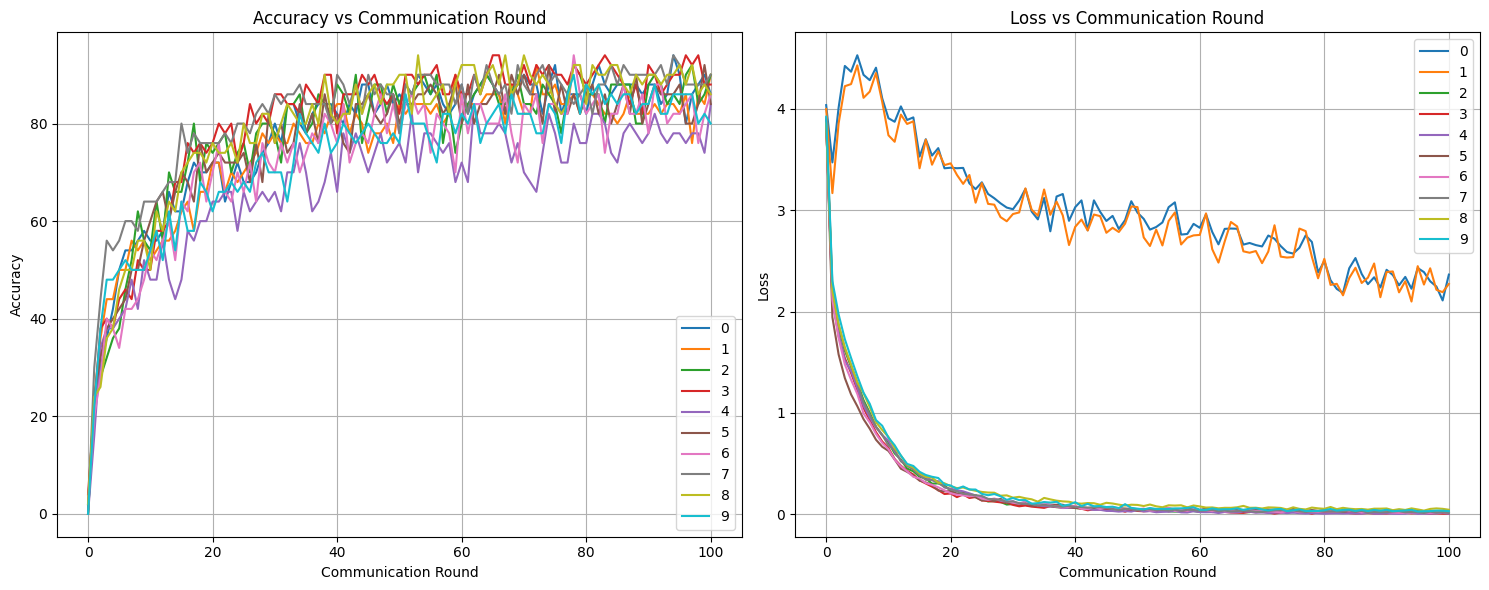

In [6]:
#train.py


import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from numpy import random
from copy import deepcopy
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.datasets import VisionDataset
from torchvision.datasets.utils import check_integrity, download_and_extract_archive

#from utils import *
exec(cell1)
#from data import *
exec(cell2)
#from LISA import *
exec(cell4)
#from VisionTransformer import *
exec(cell5)


import pickle

if torch.cuda.is_available():
        device = torch.device("cuda")
else:
        device = torch.device("cpu")

print(style.GREEN+ "\n Runtime Device:" + str(device))

def augmentClientData(dataloader,batch_size):
    from PIL import Image
    import torchvision.transforms as T
    augmented_x=[]
    augmented_y=[]
    transform=transforms.Compose([
                              transforms.RandomHorizontalFlip(),
                              transforms.RandomVerticalFlip(),
                              transforms.RandomRotation((30,90)),
                              transforms.RandomCrop([28, 28]),transforms.CenterCrop(10),
                              transforms.ColorJitter(brightness=(0.5,1.5),contrast=(1),saturation=(0.5,2),hue=(-0.1,0.4)),
                              transforms.Resize([32,32]),
                          ])
    for i in range(len((dataloader))):
        batch_x, batch_y = next(iter(dataloader))
        for j in range (len(batch_x)):
            batch_x[j]= transform(batch_x[j])
            augmented_x.append(batch_x[j])
            augmented_y.append(batch_y[j])
    tensor_x = torch.stack(augmented_x) # transform to torch tensor
    tensor_y = torch.stack(augmented_y)
    augmented_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
    augmented_dataloader = DataLoader(augmented_dataset,batch_size=batch_size, shuffle=True)
    return augmented_dataloader



def loss_classifier(predictions,labels):
    
#     m = nn.LogSoftmax(dim=1)
    loss = nn.CrossEntropyLoss()
    
    return loss(predictions ,labels)


def loss_dataset(model, dataset, loss_f):
    """Compute the loss of `model` on `dataset`"""
    loss=0
    
    for idx,(features,labels) in enumerate(dataset):
        features = features.to(device)
        labels=labels.to(device)
        predictions= model(features)
        loss+=loss_f(predictions,labels)
    
    loss/=idx+1
    return loss


def accuracy_dataset(model, dataset):
    """Compute the accuracy of `model` on `dataset`"""
    
    correct=0
    
    for features,labels in iter(dataset):
        features = features.to(device)
        labels=labels.to(device)
        predictions= model(features)
        
        _,predicted=predictions.max(1,keepdim=True)
        
        correct+=torch.sum(predicted.view(-1,1)==labels.view(-1, 1)).item()
        
    accuracy = 100*correct/len(dataset.dataset)
        
    return accuracy


def train_step(model, model_0, mu:int, optimizer, train_data, loss_f,k):
    """Train `model` on one epoch of `train_data`"""
    gradients = {}
    grads=[]
    total_loss=0
    
    for idx, (features,labels) in enumerate(train_data):
        
        optimizer.zero_grad()
        features = features.to(device)
        predictions= model(features)
        labels=labels.to(device)
        loss=loss_f(predictions,labels)
        loss+=mu/2*difference_models_norm_2(model,model_0)
        total_loss+=loss
        
        loss.backward()
#         for p in model.parameters():
#             print(f'====> {k}===> {p.grad.norm()}')
            
#             grads.append(p.grad.norm())
#         print(k)
        x=(list(model.parameters())[-1])
        if k == 2:
            grads.append(x)
        optimizer.step()
        
    return total_loss/(idx+1),grads



def local_learning(model, mu:float, optimizer, train_data, epochs:int, loss_f,k):
    
    model_0=deepcopy(model)
    
    for e in range(epochs):
        local_loss,grads=train_step(model,model_0,mu,optimizer,train_data,loss_f,k)
        
    return float(local_loss.detach().cpu().numpy()),grads


def difference_models_norm_2(model_1, model_2):
    """Return the norm 2 difference between the two model parameters
    """
    
    tensor_1=list(model_1.parameters())
    tensor_2=list(model_2.parameters())
    
    norm=sum([torch.sum((tensor_1[i]-tensor_2[i])**2) 
        for i in range(len(tensor_1))])
    
    return norm


def set_to_zero_model_weights(model):
    """Set all the parameters of a model to 0"""

    for layer_weigths in model.parameters():
        layer_weigths.data.sub_(layer_weigths.data)

def average_models(model, clients_models_hist:list , weights:list):

    """Creates the new model of a given iteration with the models of the other

    clients"""
    
    new_model=deepcopy(model)
    set_to_zero_model_weights(new_model)

    for k,client_hist in enumerate(clients_models_hist):
        
        for idx, layer_weights in enumerate(new_model.parameters()):

            contribution=client_hist[idx].data*weights[k]
            layer_weights.data.add_(contribution)
            
    return new_model
      

def FedProx(model, training_sets:list, n_iter:int,  testing_sets:list, mu=0, 
    file_name="test", epochs=5, lr=10**-2):
    """ all the clients are considered in this implementation of FedProx
    Parameters:
        - `model`: common structure used by the clients and the server
        - `training_sets`: list of the training sets. At each index is the 
            training set of client "index"
        - `n_iter`: number of iterations the server will run
        - `testing_set`: list of the testing sets. If [], then the testing
            accuracy is not computed
        - `mu`: regularization term for FedProx. mu=0 for FedAvg
        - `epochs`: number of epochs each client is running
        - `lr`: learning rate of the optimizer
        - `decay`: to change the learning rate at each iteration
    
    returns :
        - `model`: the final global model 
    """
        
    loss_f=loss_classifier
    
    #Variables initialization
    K=len(training_sets) #number of clients
    n_samples=sum([len(db.dataset) for db in training_sets])
    weights=([len(db.dataset)/n_samples for db in training_sets])
    print("Clients' weights:",weights)
    
    
    loss_hist=[[float(loss_dataset(model, dl, loss_f).detach()) 
        for dl in training_sets]]
    acc_hist=[[accuracy_dataset(model, dl) for dl in testing_sets]]
    server_hist=[[tens_param.detach().cpu().numpy()
        for tens_param in list(model.parameters())]]
    models_hist = []
    
    
    server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
    server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])
    print(f'====> i: 0 Loss: {server_loss} Server Test Accuracy: {server_acc}')
    server_loss_list=[]
    server_accuracy_list=[]  
    for i in range(n_iter):
        
        clients_params=[]
        clients_models=[]
        clients_losses=[]
        print(clients_losses)
        for k in range(K):
            local_model=deepcopy(model)
            local_optimizer=optim.Adam(local_model.parameters(),lr=0.0005)
            
            local_loss,grads=local_learning(local_model,mu,local_optimizer,
                training_sets[k],epochs,loss_f,k)
            
            clients_losses.append(local_loss)
                
            #GET THE PARAMETER TENSORS OF THE MODEL
            list_params=list(local_model.parameters())
            list_params=[tens_param.detach() for tens_param in list_params]
            clients_params.append(list_params)    
            clients_models.append(deepcopy(local_model))

            print(f"{k}---local_loss--- {local_loss}" )
        
        
        #CREATE THE NEW GLOBAL MODEL
        model = average_models(deepcopy(model), clients_params, 
            weights=weights)
        models_hist.append(clients_models)
#         print(clients_params)
#         print(weights)
        #COMPUTE THE LOSS/ACCURACY OF THE DIFFERENT CLIENTS WITH THE NEW MODEL
        loss_hist+=[[float(loss_dataset(model, dl, loss_f).detach()) 
            for dl in training_sets]]
        acc_hist+=[[accuracy_dataset(model, dl) for dl in testing_sets]]

        server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
        server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])

        print(style.GREEN+f'====> i: {i+1} Loss: {server_loss} Server Test Accuracy: {server_acc}')
        server_accuracy_list.append(server_acc)
        server_loss_list.append(server_loss)        

        server_hist.append([tens_param.detach().cpu().numpy() 
            for tens_param in list(model.parameters())])
        
        #DECREASING THE LEARNING RATE AT EACH SERVER ITERATION
            
    return model, loss_hist, acc_hist,server_accuracy_list,server_loss_list




def train (batch_size,poison,data_split,optimizer,comm_rounds,local_epochs,lr,num_clients): 
    lisa_iid_train_dls, lisa_iid_test_dls = get_LISA(data_split,
    n_samples_train =300, n_samples_test=50, n_clients =num_clients, 
    batch_size =batch_size, shuffle =True)


    if poison>0:

        poison_idx=random.randint(num_clients-1, size=(poison))

        augs = []

        for i in range (len(poison_idx)):
            lisa_iid_train_dls[i] = augmentClientData(lisa_iid_train_dls[i],batch_size)

    #model = Model().to(device)
    model = VisionTransformer(
        img_size=32,  # height and width of input images
        patch_size=8,  # size of image patches
        num_classes=47,  # number of output classes
        in_channels=3,  # number of input channels
        embed_dim=256,  # transformer embedding size
        num_layers=6,  # number of transformer layers
        heads=8,  # number of attention heads
        dropout=0.1  # dropout rate

    ).to(device)
    n_iter = comm_rounds
    model_f, loss_hist_FA_iid, acc_hist_FA_iid,server_accuracy_list,server_loss_list = FedProx( model,
    lisa_iid_train_dls, n_iter, lisa_iid_test_dls, epochs =local_epochs)


    with open('acc-10-epoch-local-1.pickle', 'wb') as handle:
        pickle.dump(acc_hist_FA_iid, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    with open('loss-10-epoch-local-1.pickle', 'wb') as handle:
        pickle.dump(loss_hist_FA_iid, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('server_acc_hist.pickle', 'wb') as handle:
        pickle.dump(server_accuracy_list, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    with open('server_loss_list.pickle', 'wb') as handle:
        pickle.dump(server_loss_list, handle, protocol=pickle.HIGHEST_PROTOCOL)
        


#main.py

import argparse
# Create the parser
import logging


#from utils import *
exec(cell1)
import gc
import torch
import math


OPTIMIZERS = ['adam', 'sgd']
SPLITS = ['iid', 'non_iid']

def read_options():
    ''' Parse command line arguments or load defaults '''
    return {
        'optimizer': 'adam',
        'data_split': 'iid',
        'num_rounds': 100,
        'clients_per_round': 10,
        'batch_size': 5,
        'num_epochs': 5,
        'learning_rate': 0.003,
        'poison': 20
    }

def main():
    # Read options
    parsed = read_options()

    # Print options
    print("\nOPTIMIZER:", parsed["optimizer"])
    print("Data Split:", parsed["data_split"])
    print("COMM_ROUNDS:", parsed["num_rounds"])
    print("POISON CLIENTS:", parsed["clients_per_round"])
    print("BATCH SIZE:", parsed["batch_size"])
    print("LOCAL EPOCHS:", parsed["num_epochs"])
    print("LEARNING RATE:", parsed["learning_rate"])
    print("POISON LEVEL:", parsed["poison"])

    poison_level = parsed["poison"]
    num_clients = parsed["clients_per_round"]
    poison_clients = math.ceil(num_clients * (poison_level / 100))
    print(poison_clients)
    if poison_clients > num_clients:
        logging.error("Poison level cannot be greater than 100 %")
    else:
        train(batch_size=parsed["batch_size"], poison=poison_clients, data_split=parsed["data_split"],
              optimizer=parsed["optimizer"], comm_rounds=parsed["num_rounds"], local_epochs=parsed["num_epochs"],
              lr=parsed["learning_rate"], num_clients=parsed["clients_per_round"])

if __name__ == '__main__':
    gc.collect()
    torch.cuda.empty_cache()
    main()

    

import pickle
import matplotlib.pyplot as plt
import pandas as pd

# Load data from pickle files
with open('acc-10-epoch-local-1.pickle', 'rb') as w:
    data_acc = pickle.load(w)

with open('loss-10-epoch-local-1.pickle', 'rb') as s:
    data_loss = pickle.load(s)

# Create DataFrames to store the accuracy and loss values
df_acc = pd.DataFrame(data_acc)
df_loss = pd.DataFrame(data_loss)

# Plot both accuracy and loss graphs side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot accuracy graph
for client in df_acc.columns:
    axes[0].plot(df_acc.index, df_acc[client], label=client)

axes[0].set_title('Accuracy vs Communication Round')
axes[0].set_xlabel('Communication Round')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot loss graph
for client in df_loss.columns:
    axes[1].plot(df_loss.index, df_loss[client], label=client)

axes[1].set_title('Loss vs Communication Round')
axes[1].set_xlabel('Communication Round')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()
